In [4]:
"""
Mostly written by Mark Ho with edits from Joe Austerweil
so students don't have the answers.

Ported to python 3 by Guangfei Zhu
Dependencies:
numpy, itertools, copy, random
"""
from itertools import product
import copy, random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow, Circle
from matplotlib.path import Path
import matplotlib.patheffects as path_effects
import matplotlib.patches as patches

def toStateActionNextstateRF(rf, tf):
    rf_value = list(rf.values())
    if type(rf_value[0]) == dict:
        is_stateRF = False
    else:
        is_stateRF = True

    temp_rf = {}
    for s, a_ns_prob in tf.items():
        temp_rf[s] = {}
        for a, ns_prob in a_ns_prob.items():
            temp_rf[s][a] = {}
            for ns, prob in ns_prob.items():
                if is_stateRF:
                    temp_rf[s][a][ns] = rf[ns]
                else:
                    temp_rf[s][a][ns] = rf[s][a]
    return temp_rf

def calc_stochastic_policy(action_vals, rand_choose=0.0):
    s_policy = {}
    if rand_choose == 0.0:
        for s, a_q in action_vals.iteritems():
            acts, qs = zip(*a_q.items())
            max_q = max(qs)
            max_acts = [acts[i] for i, qv in enumerate(qs) if qv == max_q]
            probs = [1/len(max_acts) for _ in max_acts]
            s_policy[s] = dict(zip(max_acts, probs))
    else:
        for s, a_q in action_vals.items():
            acts, qs = zip(*a_q.items())
            max_q = max(qs)
            max_acts = [acts[i] for i, qv in enumerate(qs) if qv == max_q]
            nonmax_prob = rand_choose/len(acts)
            max_prob = (1-rand_choose)/len(max_acts) + nonmax_prob
            probs = [max_prob if a in max_acts else nonmax_prob for a in acts]
            s_policy[s] = dict(zip(acts, probs))
    return s_policy

def deterministicVI(rf, tf, init_state=None, max_iterations=30, delta=0.001,
                    gamma=0.99, fixed_action_order=True, print_info=True):
    """Finds an optimal deterministic policy given a
            reward function: {s: {a: {ns : r } }, and
            transition function: {s : {a : {ns : prob}}}
    """
    rf_value = list(rf.values())
    if type(rf_value[0]) != dict:
        rf = toStateActionNextstateRF(rf, tf)
    elif type(list(rf_value[0].values())[0]) != dict:
        rf = toStateActionNextstateRF(rf, tf)

    states = [s for s in tf.keys()]
    if fixed_action_order:
        #always consistent ordering of actions
        state_actions = dict([(s, sorted(a.keys())) for s, a in tf.items()])
    else:
        #random but consistent ordering of actions
        state_actions = {}
        for s, a in tf.items():
            state_actions[s] = sorted(a.keys(), key=lambda _: random())
    vf = dict([(s, 0.0) for s in states])
    op = {}
    action_vals = {}
    for s, actions in state_actions.items():
        op[s] = actions[random.randint(0, len(actions)-1)]
        action_vals[s] = dict(zip(actions, [0.0]*len(actions)))

    for i in range(max_iterations):
        change = 0
        vf_temp = {}
        for state, actions in state_actions.items():
            max_action = actions[0]
            max_action_val = -np.inf
            for action in actions:
                #calculate expected utility of each action
                action_vals[state][action] = 0
                for ns, prob in tf[state][action].items():
                    update = prob*(rf[state][action][ns] + gamma*vf[ns])
                    action_vals[state][action] += update
                if max_action_val < action_vals[state][action]:
                    max_action = action
                    max_action_val = action_vals[state][action]
            vf_temp[state] = max_action_val
            op[state] = max_action
            change = max(change, abs(vf_temp[state]-vf[state]))
        vf = vf_temp
        if print_info:
            print('iteration: %d   change: %.2f' % (i, change))
        if change < delta:
            break
    return op, vf, action_vals

def calc_softmax_policy(action_vals, temp=1):
    soft_max_policy = {}
    for s, a_q in action_vals.items():
        a_q = a_q.items()
        sm = np.exp([(q/temp) for a, q in a_q])
        sm = list(sm/np.sum(sm))
        soft_max_policy[s] = dict(zip([a for a, q in a_q], sm))
    return soft_max_policy

def sample_prob_dict(pdict):
    outs, p_s = zip(*pdict.items())
    out_i = np.random.choice(range(len(outs)), p=p_s)
    return outs[out_i]

class Qlearning(object):
    def __init__(self, mdp,
                 decision_rule='egreedy',
                 egreedy_epsilon=.2,
                 softmax_temp=1,
                 discount_rate=None,
                 learning_rate=.25,
                 eligibility_trace_method='replacement',
                 eligiblity_trace_decay=0,
                 initial_qvalue=0,
                 init_state=None
                 ):

        self.mdp = mdp
        self.decision_rule = decision_rule
        self.egreedy_epsilon = egreedy_epsilon
        self.softmax_temp = softmax_temp
        self.learning_rate = learning_rate
        self.eligibility_trace_method = eligibility_trace_method
        self.eligiblity_trace_decay = eligiblity_trace_decay
        self.initial_qvalue = initial_qvalue
        #self.r = self.mdp.gen_reward_dict()

        self.qvalues = {}
        self.eligibility_traces = {}

        if init_state is None:
            init_state = mdp.get_init_state()
        self.init_state = init_state
        if discount_rate is None:
            discount_rate = mdp.discount_rate
        self.discount_rate = discount_rate


    def get_action(self, s):
        #initialize qvalues if not in dictionary
        if s not in self.qvalues:
            self.qvalues[s] = {}
            for a in self.mdp.available_actions(s):
                self.qvalues[s][a] = self.initial_qvalue

        #special case of a single action
        if len(self.qvalues[s]) == 1:
            s_keys = list(self.qvalues[s].keys())
            return s_keys[0]
#            return self.qvalues[s].keys()[0]

        #select a decision rule
        qs = list(self.qvalues[s].items())
        if self.decision_rule == 'egreedy':
            #print(f"qs: {qs}")
           # print('in egreedy')
            if np.random.random() > self.egreedy_epsilon:
                max_q = max(qs, key=lambda aq: aq[1])[1]
                maxactions = [a for a, q in qs if q == max_q]
                max_i = np.random.choice(range(len(maxactions)))
                return maxactions[max_i]
            else:
                ai = np.random.choice(range(len(qs)))
                return qs[ai][0]
        elif self.decision_rule == 'softmax':
            qvals = np.array([q for a, q in qs])
            qvals = np.exp(qvals/self.softmax_temp)
            probs = qvals/np.sum(qvals)
            actions = [a for a, q in qs]
            return actions[np.random.choice(range(len(qs)), p=probs)]


    def process(self, s, a, ns, r):
        #update dictionaries as needed
        if ns not in self.qvalues:
            self.qvalues[ns] = {}
            for a_ in self.mdp.available_actions(ns):
                self.qvalues[ns][a_] = self.initial_qvalue

        if s not in self.qvalues:
            self.qvalues[s] = {}
            for a_ in self.mdp.available_actions(s):
                self.qvalues[s][a_] = self.initial_qvalue


        ns_action_values = self.qvalues[ns]
        max_q_ns = max(ns_action_values.values())

        #calculate prediction error (term in parentheses of equation 1)
        # note: r = reward for this instance, s = state, and ns = next state
        # max_q_ns is the maximum q-value achieveable from next state.
        # self.discount_rate is the discount rate
        # self.q-values[s][a] is the current q-value for taking action a in state s

        #FILL IN:

        #pred_error =  #fill in
        # DONE!
        pred_error = r + (self.discount_rate * max_q_ns) - self.qvalues[s][a]

        # can uncomment for debugging information
        # print(f"cur_state: {s};       action: {a}      next_state: {ns}")
        # print(f"cur action values: {ns_action_values}")
        # print(f"current reward {r}")
        # print(f"current q_table: {self.qvalues[s][a]}")

        q_update = self.learning_rate * pred_error
        self.qvalues[s][a] += q_update


    def reset_eligibility_traces(self):
        self.eligibility_traces = {}

    def run(self,
            episodes=100, max_steps=100,
            init_state=None):
        if init_state is None:
            init_state = self.init_state


        run_data = []

        for e in range(episodes):
            s = init_state
            for t in range(max_steps):
                a = self.get_action(s)
                ns = self.mdp.transition(s=s, a=a)
                r = self.mdp.reward(s=s, a=a, ns=ns)
                # print({
                #     'episode': e, 'timestep': t,
                #     's': s, 'a': a, 'ns': ns, 'r': r
                # })
                run_data.append({
                    'episode': e, 'timestep': t,
                    's': s, 'a': a, 'ns': ns, 'r': r
                })
                self.process(s, a, ns, r)
                s = ns
                if self.mdp.is_terminal(ns):
                    break
        return run_data

    def get_softmax_policy(self, temp=1):
        return calc_softmax_policy(self.qvalues, temp)

    def get_egreedy_policy(self, rand_choose=.2):
        return calc_stochastic_policy(self.qvalues, rand_choose)

class RewardFunction(object):
    """
    TODO: implement state-action and state-action-nextstate feature rfs

    state_features : dict with mapping from states to lists of features
    feature_rewards : dict with mapping from features to reward values

    Reward is simply the sum of all features (for now). This implementation
    represents reward functions based on either states; states and actions, or
    states, actions, and nextstates. Orthogonally, it can represent them
    in tabular form, or as sums of features (over either states, states/actions,
    or states/actions/nextstates.
    """
    def __init__(self,
                 state_features=None,
                 state_rewards=None, #this is a deprecated argument
                 reward_dict=None,
                 feature_rewards=None,
                 default_reward=0,
                 terminal_states=None,
                 terminal_state_reward=0,
                 step_cost=0,
                 rmax=None,
                 cache_rewards=True):
        if terminal_states is None:
            terminal_states = [(-1, -1), (-2, -2)]
        if state_rewards is not None:
            reward_dict = state_rewards

        self.terminal_states = tuple(sorted(terminal_states))
        self.terminal_state_reward = terminal_state_reward
        self.default_reward = default_reward
#        print('self.terminal_states:',self.terminal_states)
#        print('feature_reward:',feature_rewards)

        if (state_features is not None) and (feature_rewards is not None):
            self.state_features = state_features
            self.feature_rewards = feature_rewards
            self.type = 'state_feature_based'
        elif reward_dict is not None:
            self.reward_dict = copy.deepcopy(reward_dict)
            reward_dict_value = list(reward_dict.values())
#            print(reward_dict_value[0])
            if type(reward_dict_value[0]) is dict:
                reward_dict_value_value = list(reward_dict_value[0].values())
                if type(reward_dict_value_value[0]) is dict:
                    self.type = 'state_action_nextstate_dict'
                else:
                    self.type = 'state_action_dict'
            else:
                self.type = 'state_dict'
        else:
            self.reward_dict = {}
            self.type = 'state_dict'
#        print('self.type:',self.type)

        if self.type == 'state_dict':
            for ts in terminal_states:
                self.reward_dict[ts] = terminal_state_reward

        self.step_cost = step_cost

        #set rmax
        if rmax is None:
            if self.type == 'state_dict':
                rs = list(self.reward_dict.values()) + [default_reward,]
                rmax = max(rs)
            elif self.type == 'state_action_dict':
                rmax = -np.inf
                for s, ar in self.reward_dict.items():
                    for a, r in ar.items():
                        rmax = max(rmax, r)
            elif self.type == 'state_feature_based':
                fr = np.array(self.feature_rewards.values())
                pos_fr = fr[fr>0]
                if (len(pos_fr) == 0):
                    pos_fr = [max(fr),]
                rmax = np.sum(pos_fr)
            else:
                raise ValueError("Cannot set Rmax")
        self.rmax = rmax

        self.reward_cache = {}
        self.cache_rewards = cache_rewards

    def reward(self, s=None, a=None, ns=None):

        if self.type == 'state_dict':
            reward = self.reward_dict.get(ns, self.default_reward)
        elif self.type == "state_action_dict":
            if s not in self.reward_dict:
                reward = self.default_reward
            else:
                reward = self.reward_dict[s].get(a, self.default_reward)
        elif self.type == "state_action_nextstate_dict":
            if s not in self.reward_dict:
                reward = self.default_reward
            elif a not in self.reward_dict[s]:
                reward = self.default_reward
            else:
                reward = self.reward_dict[s][a].get(ns, self.default_reward)
        elif self.type == 'state_feature_based':
            if ns in self.terminal_states:
                reward = self.terminal_state_reward
            elif self.cache_rewards:
                if ns not in self.reward_cache:
                    fs = self.state_features.get(ns, [])
                    r = 0
                    for f in fs:
                        r += self.feature_rewards.get(f, self.default_reward)
                    self.reward_cache[ns] = r
                reward = self.reward_cache[ns]
            else:
                fs = self.state_features.get(ns, [])
                reward = np.sum([self.feature_rewards[f] for f in fs])
        elif self.type == 'state_action_feature_based':
            pass

        elif self.type == 'state_action_nextstate_feature_based':
            pass

        if ns in self.terminal_states:
            return reward
        else:
            return reward + self.step_cost

    def gen_reward_dict(self, states=None, state_actions=None,
                        state_action_nextstates=None, tf=None,
                        include_actions=False, include_nextstates=False):
        # ================================================ #
        #  Generate a state-action-nextstate rf dictionary #
        # ================================================ #
        if (include_actions and include_nextstates) \
                or self.type in ['state_action_nextstate_dict',\
                                 'state_action_nextstate_feature_based']:
            rf ={}
            for s, a_ns in state_action_nextstates.iteritems():
                rf[s] = {}
                for a, nstates in a_ns.items():
                    rf[s][a] = {}
                    for ns in nstates:
                        #=========================================#
                        #      Handle the different rf types      #
                        #=========================================#
                        if self.type in ['state_dict', 'state_feature_based']:
                            rf[s][a][ns] = self.reward(ns=ns)

                        elif self.type in ['state_action_dict',
                                           'state_action_feature_based']:
                            rf[s][a][ns] = self.reward(s=s, a=a)

                        elif self.type in ['state_action_nextstate_dict',
                                           'state_action_nextstate_feature_based']:
                            rf[s][a][ns] = self.reward(s=s, a=a, ns=ns)

                        else:
                            raise ValueError("Undefined reward function dictionary!")
        # ================================================ #
        #       Generate a state-action rf dictionary      #
        # ================================================ #
        elif include_actions or self.type in ['state_action_dict',
                                              'state_action_feature_based']:
            rf = {}
            # ======================================== #
            #      Handle the different rf types       #
            # ======================================== #
            if self.type in ['state_dict', 'state_feature_based']:
                for s, a_ns in state_action_nextstates.items():
                    rf[s] = {}
                    for a, nstates in a_ns.items():
                        if len(nstates) > 1:
                            raise ValueError("Undefinable reward function dictionary!")
                        rf[s][a] = self.reward(ns=nstates[0])
            elif self.type in ['state_action_dict','state_action_feature_based']:
                for s, actions in state_actions.items():
                    rf[s] = {}
                    for a in actions:
                        rf[s][a] = self.reward(s=s, a=a)
            else:
                raise ValueError("Undefined reward function dictionary!")

        # ================================================ #
        #           Generate a state rf dictionary         #
        # ================================================ #
        elif self.type in ['state_dict', 'state_feature_based']:
            rf = {ns: self.reward(ns=ns) for ns in states}
        else:
            raise ValueError("Undefined reward function dictionary!")
        return rf

    def __hash__(self):
        try:
            return self.hash
        except AttributeError:
            pass

        #todo write a test for this hash function
        myhash = [self.type,
                  self.terminal_state_reward,
                  self.terminal_states,
                  self.default_reward,
                  self.step_cost]

        if self.type == 'state_dict':
            myhash.extend([
                tuple(sorted(self.reward_dict.items())),
            ])
        else:
            myhash.extend([
                False,
            ])

        if self.type == 'state_action_dict':
            sar = []
            for s, ar in self.reward_dict.items():
                ar = tuple(sorted(ar.items()))
                sar.append((s, ar))
            sar = tuple(sorted(sar))
            myhash.extend([sar,])
        else:
            myhash.extend([False,])

        if self.type == 'state_action_nextstate_dict':
            sansr = []
            for s, ansr in self.reward_dict.items():
                ansr_ = []
                for a, nsr in ansr.iteritems():
                    nsr = tuple(sorted(nsr.items()))
                    ansr_.append((a, nsr))
                ansr_ = tuple(sorted(ansr_))
                sansr.append(ansr_)
            sansr = tuple(sorted(sansr))
            myhash.extend([sansr,])
        else:
            myhash.extend([False,])

        if self.type == 'state_feature_based':
            myhash.extend([
                tuple(sorted(self.state_features.items())),
                tuple(sorted(self.feature_rewards.items()))
            ])
        else:
            myhash.extend([False,
                           False])

        self.hash = hash(tuple(myhash))

        return hash(tuple(myhash))

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return hash(self) == hash(other)
        return False


class MDP(object):
    def __init__(self):
        pass

    def is_terminal(self, s):
        raise NotImplementedError

    def transition(self, s, a):
        raise NotImplementedError

    def reward(self, s=None, a=None, ns=None):
        raise NotImplementedError

    def available_actions(self, s):
        raise NotImplementedError

    def solve(self):
        raise NotImplementedError

    def state_hasher(self, state):
        raise NotImplementedError

    def state_unhasher(self, hashed):
        raise NotImplementedError

    def get_optimal_policy(self):
        raise NotImplementedError

    def get_softmax_function(self, temp):
        raise NotImplementedError

    def get_init_state(self):
        raise NotImplementedError

    def gen_transition_dict(self):
        raise NotImplementedError

    def calc_trajectory_return(self, traj, init_state=None, discount=1):
        value = 0

        if len(traj[0]) == 1:
            ns = init_state

        for tup in traj:
            if len(tup) == 3:
                s, a, ns = tup
            elif len(tup) == 2:
                s, a = tup
                ns = self.transition(s, a)
            elif len(tup) == 1:
                a = tup
                s = ns
                ns = self.transition(s, a)
            value += self.reward(s=s, a=a, ns=ns)*discount
        return value

    def build_transition_graph(self, init_state, max_nodes=np.inf):
        graph = {}
        frontier = [init_state, ]

        while len(graph) < max_nodes:
            s = frontier.pop()

    def run(self, policy=None, init_state=None, max_steps=25, temp=1):
        traj = []
        if init_state is None:
            init_state = self.get_init_state()
        if policy is None:
            policy = self.get_softmax_function(temp)
        s = init_state
        i = 0
        while i < max_steps:
            a = sample_prob_dict(policy[s])
            ns = self.transition(s, a)
            r = self.reward(s, a, ns)
            traj.append((s, a, ns, r))
            s = ns
            if self.is_terminal(s):
                break
        return traj


class GridWorld(MDP):
    """
      Class defining a GridWorld object, which is a special case
      of more general MDPs
    """

    def __init__(self, width=None, height=None,
                 gridworld_array=None,
                 wait_action=False,
                 wall_action=False,
                 state_features=None,
                 absorbing_states=None,
                 slip_states=None,
                 slip_features=None,
                 sticky_states=None,
                 non_std_t_states=None,
                 non_std_t_features=None,
                 walls=None, #[((x, y), side),...]
                 starting_states=None,
                 state_rewards=None, #deprecated
                 reward_dict=None,
                 default_reward=0,
                 step_cost=0,
                 feature_rewards=None,
                 include_intermediate_terminal=False,
                 init_state=None,
                 state_types=None,
                 feature_types=None,
                 discount_rate=None):

        if gridworld_array is not None:
            w = len(gridworld_array[0])
            h = len(gridworld_array)
            state_features = {(x, y): gridworld_array[h - 1 - y][x] for x, y in
                              product(range(w), range(h))}
            width = w
            height = h

        self.width = width
        self.height = height
        self.states = list(product(range(width), range(height))) + [(-1,-1),(-2,-2)]
        self.wait_action = wait_action
        self.wall_action = wall_action
        self.cached_transitions = {}
        self.include_intermediate_terminal = include_intermediate_terminal
        self.intermediate_terminal = (-2, -2)
        self.terminal_state = (-1, -1)

        if absorbing_states is None:
            absorbing_states = []
        absorbing_states = copy.deepcopy(absorbing_states)
        self.absorbing_states = frozenset(absorbing_states)

        if state_features is None:
            state_features = {}
        self.state_features = state_features

        #non-standard transitions
        non_std_t_moves = ['forward', 'back', 'left', 'right',
                           '2forward', '2back', 'horseleft',
                           'horseright', 'diagleft', 'diagright',
                           'stay']
        self.non_std_t_moves = non_std_t_moves
        non_std_t_states = copy.deepcopy(non_std_t_states)

        if non_std_t_states is None:
            non_std_t_states = {}

        if slip_states is not None:
            non_std_t_states.update(slip_states)

        if non_std_t_features is None:
            non_std_t_features = {}
        if slip_features is not None:
            non_std_t_features.update(slip_features)

        if state_types is None:
            state_types = {}

        if feature_types is None:
            feature_types = {}

        for s in self.states:
            f = state_features.get(s, None)
            if f in non_std_t_features:
                non_std_t_states[s] = non_std_t_features[f]
            if f in feature_types:
                state_types[s] = state_types.get(s, [])
                state_types[s].append(feature_types[f])

        for s, non_std_t in non_std_t_states.items():
            if 'side' in non_std_t:
                non_std_t['left'] = non_std_t['side'] / 2
                non_std_t['right'] = non_std_t['side'] / 2
                del non_std_t['side']
            if 'horsemove' in non_std_t:
                non_std_t['horseleft'] = non_std_t['horsemove'] / 2
                non_std_t['horseright'] = non_std_t['horsemove'] / 2
                del non_std_t['horsemove']
            if 'diag' in non_std_t:
                non_std_t['diagleft'] = non_std_t['diag'] / 2
                non_std_t['diagright'] = non_std_t['diag'] / 2
                del non_std_t['diag']
            non_std_t = [non_std_t.get(move, 0) for move in non_std_t_moves]
            non_std_t_states[s] = non_std_t
        self.non_std_t_states = non_std_t_states
        self.state_types = state_types

        #walls
        if walls is None:
            walls = []
        self.walls = walls

        #initial states
        if starting_states is None:
            starting_states = []
        starting_states = copy.deepcopy(starting_states)

        if init_state is not None:
            starting_states.append(init_state)
        self.starting_states = frozenset(starting_states)

        # reward function stuff
        self.reward_function = RewardFunction(state_features=state_features,
                                              state_rewards=state_rewards,
                                              feature_rewards=feature_rewards,
                                              reward_dict=reward_dict,
                                              default_reward=default_reward,
                                              step_cost=step_cost)
        self.rmax = self.reward_function.rmax
        self.terminal_state_reward = self.reward_function.terminal_state_reward

        n_actions = 4

        if self.wait_action:
            n_actions += 1
        self.n_actions = n_actions

        self.reward_cache = {}
        self.transition_cache = {}
        self.available_action_cache = {}
        self.discount_rate = discount_rate

    def __hash__(self):
        try:
            return self.hash
        except AttributeError:
            pass

        self.hash = hash((
            self.width,
            self.height,
            self.wait_action,
            self.wall_action,
            self.reward_function,
            self.absorbing_states,
            frozenset([(s, nst) for s, nst in self.non_std_t_states.iteritems()]),
            self.starting_states,
            self.include_intermediate_terminal,
            self.intermediate_terminal,
            self.terminal_state
        ))
        return self.hash

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return hash(self) == hash(other)
        return False

    # ============================================== #
    #                                                #
    #                                                #
    #          State/Action Related Methods          #
    #                                                #
    #                                                #
    # ============================================== #

    def is_terminal(self, s):
        return s == self.terminal_state

    def is_any_terminal(self, s):
        return s in [self.terminal_state, self.intermediate_terminal]

    def is_absorbing(self, s):
        return s in self.absorbing_states

    def state_hasher(self, state):
        return state

    def state_unhasher(self, hashed):
        return hashed

    def get_init_state(self):
        if len(self.starting_states) == 0:
            raise ValueError('No initial state defined')
        starting_states = list(self.starting_states)
        i = np.random.choice(len(starting_states))
        return starting_states[i]

    def available_actions(self, s):
        try:
            return self.available_action_cache[s]
        except:
            pass
        actions = []

        # handle absorbing, terminal, and intermediate terminal states
        if s in self.absorbing_states:
            actions.append('%')
        elif s == self.terminal_state:
            actions.append('%')
        elif s == self.intermediate_terminal:
            actions.append('%')

#         handle 'normal' transitions with no wall actions
        elif not self.wait_action:
            if s[1] < self.height - 1 and (s, '^') not in self.walls:
                actions.append('^')
            if s[1] > 0 and (s, 'v') not in self.walls:
                actions.append('v')
            if s[0] < self.width - 1 and (s, '>') not in self.walls:
                actions.append('>')
            if s[0] > 0 and (s, '<') not in self.walls:
                actions.append('<')
        elif self.wall_action:
            actions.extend(['^','v','<','>'])

        if self.wait_action:
            actions.append('x')

        self.available_action_cache[s] = actions

        return actions

    # ============================================== #
    #                                                #
    #                                                #
    #          Transition Function Methods           #
    #                                                #
    #                                                #
    # ============================================== #

    def _normal_transition(self, s, a):
        """
        "normal" transitions (taking into account walls)
        """

        # handle walls
        if (s, a) in self.walls:
            res = s

        #handle non-wall transitions
        elif s[1] < self.height - 1 and a == '^':
            res = s[0], s[1] + 1
        elif s[1] > 0 and a == 'v':
            res = s[0], s[1] - 1
        elif s[0] < self.width - 1 and a == '>':
            res = s[0] + 1, s[1]
        elif s[0] > 0 and a == '<':
            res = s[0] - 1, s[1]
        elif a == 'x':
            res = s

        #handle default transition
        else:
            res = s
        return res

    def _get_side_actions(self, a):
        if a in '^v':
            return ['<', '>']
        elif a in '<>':
            return ['^', 'v']
        else:
            return a

    def _get_back_action(self, a):
        if a == '^':
            a_ = 'v'
        elif a == 'v':
            a_ = '^'
        elif a == '<':
            a_ = '>'
        elif a == '>':
            a_ = '<'
        else:
            a_ = a
        return a_

    def _get_right_action(self, a):
        if a == '>':
            return 'v'
        elif a == 'v':
            return '<'
        elif a == '<':
            return '^'
        elif a == '^':
            return '>'
        else:
            return a

    def _get_left_action(self, a):
        if a == '>':
            return '^'
        elif a == 'v':
            return '>'
        elif a == '<':
            return 'v'
        elif a == '^':
            return '<'
        else:
            return a

    def transition_dist(self, s, a):
        try:
            return self.transition_cache[(s, a)]
        except KeyError:
            pass

        dist = {}

        # handle absorbing, terminal, and intermediate terminal states
        if s in self.absorbing_states:
            if self.include_intermediate_terminal:
                dist = {self.intermediate_terminal : 1}
            else:
                dist = {self.terminal_state : 1}

        elif s == self.terminal_state:
            dist = {self.terminal_state : 1}

        elif s == self.intermediate_terminal:
            dist = {self.terminal_state : 1}

        #non-standard transition states
        elif s in self.non_std_t_states:
            nst = self.non_std_t_states[s]

            for mi, move in enumerate(self.non_std_t_moves):
                p = nst[mi]
                if p == 0:
                    continue

                if move == 'forward':
                    res = self._normal_transition(s, a)
                elif move == 'back':
                    a_ = self._get_back_action(a)
                    res = self._normal_transition(s, a_)
                elif move == 'left':
                    a_ = self._get_left_action(a)
                    res = self._normal_transition(s, a_)
                elif move == 'right':
                    a_ = self._get_right_action(a)
                    res = self._normal_transition(s, a_)
                elif move == '2forward':
                    ns = self._normal_transition(s, a)
                    res = self._normal_transition(ns, a)
                elif move == '2back':
                    a_ = self._get_back_action(a)
                    ns = self._normal_transition(s, a_)
                    res = self._normal_transition(ns, a_)
                elif move == 'horseleft':
                    ns = self._normal_transition(s, a)
                    ns = self._normal_transition(ns, a)
                    a_ = self._get_left_action(a)
                    res = self._normal_transition(ns, a_)
                elif move == 'horseright':
                    ns = self._normal_transition(s, a)
                    ns = self._normal_transition(ns, a)
                    a_ = self._get_right_action(a)
                    res = self._normal_transition(ns, a_)
                elif move == 'diagleft':
                    ns = self._normal_transition(s, a)
                    a_ = self._get_left_action(a)
                    res = self._normal_transition(ns, a_)
                elif move == 'diagright':
                    ns = self._normal_transition(s, a)
                    a_ = self._get_right_action(a)
                    res = self._normal_transition(ns, a_)
                elif move == 'stay':
                    res = s
                dist[res] = dist.get(res, 0)
                dist[res] += p

        #"normal" transitions (taking into account walls)
        else:
            ns = self._normal_transition(s, a)
            dist = {ns: 1}

        self.transition_cache[(s, a)] = dist
        return dist

    def transition(self, s, a):
        dist = self.transition_dist(s, a)
        ns, p = zip(*list(dist.items()))
        return ns[np.random.choice(len(ns), p=p)]

    def gen_transition_dict(self):
        tf = {}
        for s in self.states:
            tf[s] = {}
            for a in self.available_actions(s):
                tf[s][a] = self.transition_dist(s, a)
        return tf

    def expected_transition(self, s, a):
        """Transition assuming no walls or whatever"""
        if a == '^':
            res = s[0], s[1]+1
        elif a == 'v':
            res = s[0], s[1] - 1
        elif a == '>':
            res = s[0] + 1, s[1]
        elif a == '<':
            res = s[0] - 1, s[1]
        else:
            res = s
        return res

    # ============================================== #
    #                                                #
    #                                                #
    #             Reward Function Methods            #
    #                                                #
    #                                                #
    # ============================================== #

    def reward(self, s=None, a=None, ns=None):
        try:
            return self.reward_cache[(s, a, ns)]
        except KeyError:
            pass
        res = self.reward_function.reward(s=s, a=a, ns=ns)
        self.reward_cache[(s, a, ns)] = res
        return res

    def gen_reward_dict(self, include_actions=False, include_nextstates=False):
        state_actions = {s: self.available_actions(s) for s in self.states}
#        print(state_actions)
        state_action_nextstates = {}
        for s in self.states:
            state_action_nextstates[s] = {}
            for a in self.available_actions(s):
#                print(self.transition_dist(s, a), type(self.transition_dist(s,a).keys()))
                state_action_nextstates[s][a] = self.transition_dist(s, a).keys()
#                              copy.deepcopy(self.transition_dist(s, a).keys())
        rf = self.reward_function.gen_reward_dict(
                states=self.states,
                state_actions=state_actions,
                state_action_nextstates=state_action_nextstates,
                tf={},
                include_actions=include_actions,
                include_nextstates=include_nextstates)


        return rf

    # ============================================== #
    #                                                #
    #                                                #
    #              Computation Methods               #
    #                                                #
    #                                                #
    # ============================================== #

    def solve(self, start_state=None, silent=False, **kwargs):
        if 'gamma' not in kwargs and self.discount_rate is not None:
            kwargs['gamma'] = self.discount_rate
        rf = self.gen_reward_dict()
        tf = self.gen_transition_dict()
        op, vf, av = deterministicVI(rf, tf, init_state=start_state, print_info=not silent, **kwargs)
        self.optimal_policy = op
        self.value_function = vf
        self.action_value_function = av

        self.solved = True
        return

    def get_optimal_policy(self):
        if not self.solved:
            raise ValueError("No optimal policy computed")
        return self.optimal_policy

    def get_softmax_function(self, temp=1):
        return calc_softmax_policy(self.action_value_function, temp)

# ================================#
#
#	Visualization stuff
#
# ================================#

def visualize_states(ax=None, states=None,
                     tile_color=None,
                     plot_size=None,
                     panels=None,
                     **kwargs):
    '''
        Supported kwargs:
            - tile_color : a dictionary from tiles (states) to colors
            - plot_size is an integer specifying how many tiles wide
              and high the plot is, with the grid itself in the middle
    '''
    if tile_color is None:
        tile_color = {}

    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if panels is None:
        panels = []

    # plot squares
    for s in states:
        if s == (-1, -1):
            continue
        square = Rectangle(xy=s, width=1, height=1, color=tile_color.get(s, 'white'),\
                           ec='k', lw=2)
        ax.add_patch(square)

    ax.axis('off')
    if plot_size is None and len(panels) == 0:
        ax.set_xlim(-0.1, 1 + max([s[0] for s in states]) + .1)
        ax.set_ylim(-0.1, 1 + max([s[1] for s in states]) + .1)
        ax.axis('scaled')
    elif len(panels) > 0:
        xlim = [-0.1, 1 + max([s[0] for s in states]) + .1]
        ylim = [-0.1, 1 + max([s[1] for s in states]) + .1]
        if 'right' in panels:
            xlim[1] += 2
        if 'left' in panels:
            xlim[0] -= 2
        if 'top' in panels:
            ylim[1] += 2
        if 'bottom' in panels:
            ylim[0] -= 2
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
    else:
        cx = (max([s[0] for s in states]) + 1) / 2
        cy = (max([s[1] for s in states]) + 1) / 2
        ax.set_xlim(cx - 0.1 - plot_size / 2, cx + 0.1 + plot_size / 2)
        ax.set_ylim(cy - 0.1 - plot_size / 2, cy + 0.1 + plot_size / 2)
    return ax

def visualize_deterministic_policy(ax, policy, absorbing_action='%', **kwargs):
    m = [(s, {a: 1.0}) for s, a in policy.items() if a != absorbing_action]
    policy = dict(m)
    return visualize_action_values(ax, policy, **kwargs)

def visualize_action_values(ax=None, state_action_values=None,
                            color_valence=False,
                            global_maxval=None, **kwargs):
    '''
        Supported kwargs:
            - color_valence : boolean whether to color negative red and positive blue, otherwise color is always black
            - global_maxval : max value to normalize arrow lengths to
    '''

    # plot arrows
    if global_maxval is None:
        global_maxval = -np.inf
        for s, a_v in state_action_values.items():
            for v in a_v.values():
                if global_maxval < np.absolute(v):
                    global_maxval = np.absolute(v)

    for s, a_v in state_action_values.items():
        if s == (-1, -1):
            continue
        x, y = s
#        normalization = np.sum(np.absolute(a_v.values()))
#        maxval = max(np.absolute(a_v.values()))
        for a, v in a_v.items():
            if a == '%' or v == 0:
                continue

            mag = (.5 / global_maxval) * np.absolute(v)

            if color_valence:
                if v <= 0:
                    arrowColor = 'red'
                else:
                    arrowColor = 'blue'
            else:
                arrowColor = 'k'
            arrowwidth = .1
            if a == '<':
                ax.add_patch(Arrow(x + .5, y + .5, -mag, 0, width=arrowwidth,
                                   color=arrowColor))
            elif a == '>':
                ax.add_patch(Arrow(x + .5, y + .5, mag, 0, width=arrowwidth,
                                   color=arrowColor))
            elif a == 'v':
                ax.add_patch(Arrow(x + .5, y + .5, 0, -mag, width=arrowwidth,
                                   color=arrowColor))
            elif a == '^':
                ax.add_patch(Arrow(x + .5, y + .5, 0, mag, width=arrowwidth,
                                   color=arrowColor))
            elif a == 'x':
                ax.add_patch(
                    Circle((x + .5, y + .5), radius=mag * .9, fill=False))
            else:
                raise Exception('unknown action')
    return ax

def visualize_trajectory(axis, traj,
                         jitter_mean=0,
                         jitter_var=.1,
                         plot_actions=False,
                         endpoint_jitter=False,
                         color='black',
                         **kwargs):

    traj = [(t[0], t[1]) for t in traj]  # traj only depends on state actions

    if len(traj) == 2:
        p0 = tuple(np.array(traj[0][0]) + .5)
        p2 = tuple(np.array(traj[1][0]) + .5)
        p1 = np.array([(p0[0] + p2[0]) / 2, (p0[1] + p2[1]) / 2]) \
             + np.random.normal(0, jitter_var, 2)
        if endpoint_jitter:
            p0 = tuple(
                np.array(p0) + np.random.normal(jitter_mean, jitter_var, 2))
            p1 = tuple(
                np.array(p1) + np.random.normal(jitter_mean, jitter_var, 2))
        segments = [[p0, p1, p2], ]
    elif (len(traj) == 3) and (traj[0][0] == traj[2][0]):
        p0 = tuple(np.array(traj[0][0]) + .5)
        p2 = tuple(np.array(traj[1][0]) + .5)
        if abs(p0[0] - p2[0]) > 0:  # horizontal
            jitter = np.array(
                [0, np.random.normal(jitter_mean, jitter_var * 2)])
            p2 = p2 - np.array([.25, 0])
        else:  # vertical
            jitter = np.array(
                [np.random.normal(jitter_mean, jitter_var * 2), 0])
            p2 = p2 - np.array([0, .25])
        p1 = p2 + jitter
        p3 = p2 - jitter
        segments = [[p0, p1, p2], [p2, p3, p0]]
    else:
        state_coords = []
        for s, a in traj:
            jitter = np.random.normal(jitter_mean, jitter_var, 2)
            coord = np.array(s) + .5 + jitter
            state_coords.append(tuple(coord))
        if not endpoint_jitter:
            state_coords[0] = tuple(np.array(traj[0][0]) + .5)
            state_coords[-1] = tuple(np.array(traj[-1][0]) + .5)
        join_point = state_coords[0]
        segments = []
        for i, s in enumerate(state_coords[:-1]):
            ns = state_coords[i + 1]

            segment = []
            segment.append(join_point)
            segment.append(s)
            if i < len(traj) - 2:
                join_point = tuple(np.mean([s, ns], axis=0))
                segment.append(join_point)
            else:
                segment.append(ns)
            segments.append(segment)

    for segment, step in zip(segments, traj[:-1]):
        state = step[0]
        action = step[1]

        codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
        path = Path(segment, codes)
        patch = patches.PathPatch(path, facecolor='none', capstyle='butt',
                                  edgecolor=color, **kwargs)
        axis.add_patch(patch)
        if plot_actions:
            dx = 0
            dy = 0
            if action == '>':
                dx = 1
            elif action == 'v':
                dy = -1
            elif action == '^':
                dy = 1
            elif action == '<':
                dx = -1
            action_arrow = patches.Arrow(segment[1][0], segment[1][1],
                                         dx * .4,
                                         dy * .4,
                                         width=.25,
                                         color='grey')
            axis.add_patch(action_arrow)


def plot_text(axis, state, text, outline=False, outline_linewidth=1,
              outline_color='black',
              x_offset=0, y_offset=0, **kwargs):
    mytext = axis.text(state[0] + .5 + x_offset, state[1] + .5 + y_offset,
                       text, **kwargs)
    if outline:
        mytext.set_path_effects([path_effects.Stroke(
            linewidth=outline_linewidth, foreground=outline_color),
            path_effects.Normal()])

POS_FB = 10
NEG_FB = -10
NO_FB = 0
GOAL_FB  = 15
discount_rate = .95
state_action_reward_function = True

rm_fb = {(0,0): {'>': NEG_FB, '^': NO_FB},
         (0,1): {'v': NO_FB, '>': NEG_FB, '^': NO_FB},
         (0,2): {'v': NO_FB, '>': NO_FB},
         (1,0): {'<': NO_FB, '>': NEG_FB, '^': NEG_FB},
         (2,0): {'<': NEG_FB, '^': NEG_FB},
         (1,1): {'v': NEG_FB, '<': NO_FB, '>': NEG_FB, '^': NO_FB},
         (1,2): {'<': NO_FB, 'v': NEG_FB, '>': GOAL_FB},
         (2,1): {'<': NEG_FB, 'v': NEG_FB, '^': GOAL_FB}}

af_fb = {(0,0): {'>': NEG_FB, '^':POS_FB},
         (0,1): {'v': NEG_FB, '^': POS_FB, '>': NEG_FB},
         (0,2): {'v': NEG_FB, '>': POS_FB},
         (1,0): {'<': POS_FB, '^': NEG_FB, '>':NEG_FB},
         (1,1): {'<': NEG_FB, '^': POS_FB, 'v': NEG_FB, '>': NEG_FB},
         (1,2): {'<': NEG_FB, 'v': NEG_FB, '>': GOAL_FB},
         (2,0): {'<': NEG_FB, '^':POS_FB},
         (2,1): {'<': NEG_FB, 'v': NEG_FB, '^': GOAL_FB}}

def solve_and_plot(params, silent=False):
    gw = GridWorld(**params)

    gw.solve(gw.get_init_state(), silent=silent, gamma=discount_rate)
    if not silent is False:
        print('='*100)

    myQlearning = Qlearning(mdp=gw, discount_rate=discount_rate, learning_rate=0.10)
    myQlearning.run(episodes=1000)


    fig = plt.figure(figsize=(10, 8))
    f_colors = {
            'z': 'grey',
            'x': 'lightgrey',
            'y': 'yellow',
            '.': 'white',
            'g': 'yellow'}

    t_colors = {s: f_colors[f] for s, f in gw.state_features.items()}

    tiles = list(product(range(gw.width), range(gw.height)))

    if silent is False:
        print("=======================Q-Learning Result=============================")
    fig2 = plt.figure(figsize=(10, 8))
    # plot action value function
    ax = fig2.add_subplot(2, 2, 1)
    visualize_states(ax=ax, states=tiles, tile_color=t_colors)
    visualize_action_values(ax=ax,
                            state_action_values=myQlearning.qvalues,
                            color_valence=True)
    ax.set_title(
        "Q-Leaning Action-Value \nFunction (discount = %.2f)" % discount_rate)
    
    if silent is False:
        print(myQlearning.qvalues)

    # plot optimal deterministic policy
    #ax = fig2.add_subplot(2, 3, 3)
    #visualize_states(ax=ax, states=tiles, tile_color=t_colors)
    #visualize_deterministic_policy(ax, myQlearning.get_egreedy_policy())
    #ax.set_title(
    #    "Q-learning \nPolicy (discount = %.2f)" % discount_rate)

    # plot softmax policy
    ax = fig2.add_subplot(2, 2, 2)
    visualize_states(ax=ax, states=tiles, tile_color=t_colors)
    softmaxtemp = 5
    softmax_policy = myQlearning.get_softmax_policy()
    #calc_softmax_policy(myQlearning.mdp.action_value_function,
    #                                     temp=softmaxtemp)
    visualize_action_values(ax, softmax_policy)
    ax.set_title(
        "Q-Softmax Policy\n(discount = %.2f,\ntemp = %.2f)" %
        (discount_rate, softmaxtemp))


    # plot trajectory
    ax = fig2.add_subplot(2, 2, 3)
    visualize_states(ax=ax, states=tiles, tile_color=t_colors)
    traj = []
    s = (0, 0)
    for _ in range(25):
        a = myQlearning.get_action(s)
        ns = myQlearning.mdp.transition(s, a)
        traj.append((s, a, ns))
        if myQlearning.mdp.is_terminal(ns):
            break
        s = ns
    visualize_trajectory(ax, traj, plot_actions=False)
    ax.set_title("Q-Learning \nTrajectory Example 1")

    ax = fig2.add_subplot(2, 2, 4)
    visualize_states(ax=ax, states=tiles, tile_color=t_colors)
    traj = []
    s = (1, 0)
    for _ in range(25):
        a = myQlearning.get_action(s)
        ns = myQlearning.mdp.transition(s, a)
        traj.append((s, a, ns))
        if myQlearning.mdp.is_terminal(ns):
            break
        s = ns
    visualize_trajectory(ax, traj, plot_actions=False)
    ax.set_title("Q-Learning \nTrajectory Example 2")

# Notes For Joe

Hi, Joe! It was a bit challenging to get the results we expected based on Ho et al. In particular, the policies learned during training don't exhibit the differences expected between teaching styles unless the model is allowed to *thoroughly* explore the state-action space. In particular, based on repeated runs of the Action-Feedback-trained model, it seems highly unlikely to gain the cycle behavior over a small number of episodes. Raising the number of episodes from 100 to 1000 did the trick and allows the model to more consistently learn the cycle behavior. I am unsure whether I did something wrong in order for this to be the case.

## 2 Reward-Maximizing Feedback

<Figure size 1000x800 with 0 Axes>

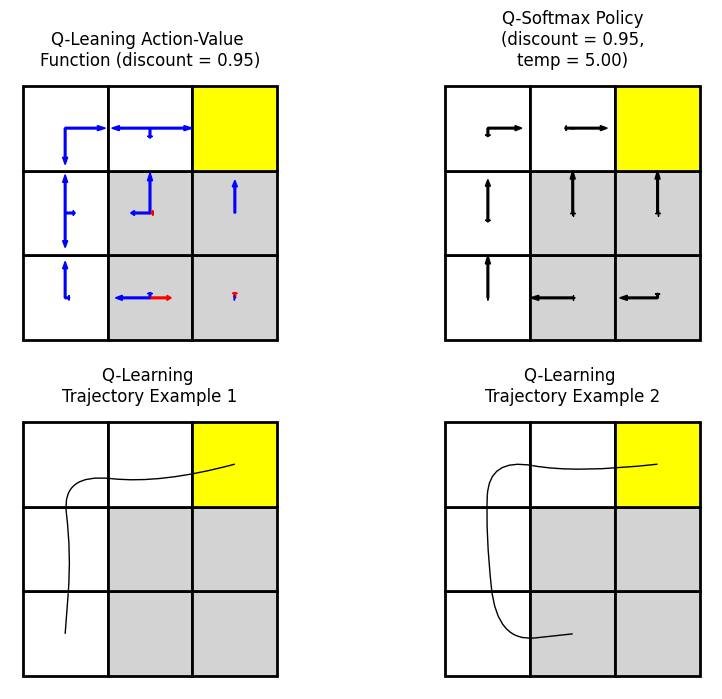

In [5]:
params = {
        'gridworld_array': ['..g', '.xx', '.xx'],
        'reward_dict': rm_fb, # reward-maximizing feedback
        'init_state': (0, 0),
        'absorbing_states': [(2, 2), ]}
solve_and_plot(params, silent=True)

*Did it do what you expected?*

Yes, the policy learned directs the agent away from the danger tiles toward safe tiles, and from safe tiles toward the goal. From previous classroom learning, I know that a reward-optimizing agent that is explores the state-action space sufficiently and is exposed to goal-driven feedback will eventually learn an optimal policy.

*Does the learned policy make sense? In a few sentences, explain why or why not.*

The learned policy makes sense. It dirves the agent toward safe tiles and directs them toward the goal once safe.

## 3 Action-Feedback Feedback

<Figure size 1000x800 with 0 Axes>

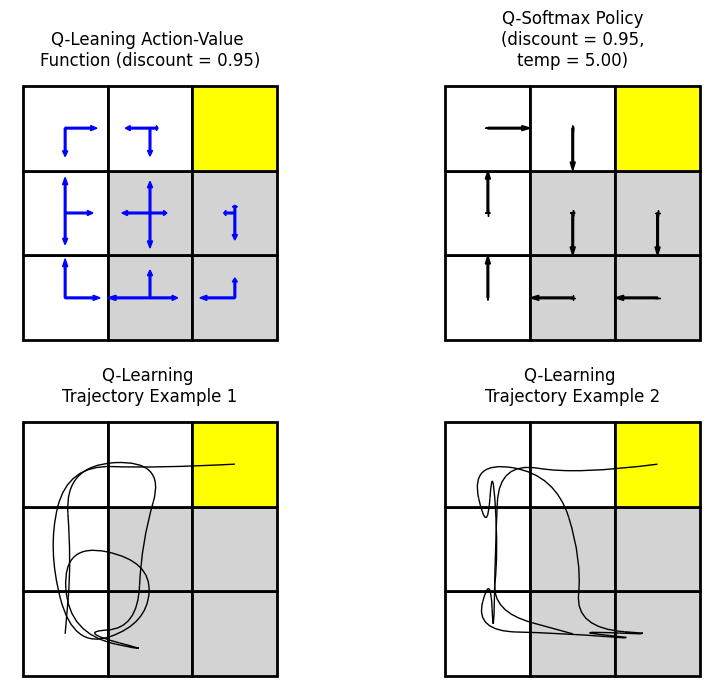

In [8]:
params = {
        'gridworld_array': ['..g', '.xx', '.xx'],
        'reward_dict': af_fb, # action_feedback reward function
        'init_state': (0, 0),
        'absorbing_states': [(2, 2), ]}
solve_and_plot(params, silent=True)

*Did it do what you expected?*

The policy was learned as I would have expected from Ho et al. I expected it to eventually pick up on the cycle that allows it to gain infinite reward.

*Does the learned policy make sense? In a few sentences, explain why or why not.*

The learned policy does not make sense from the perspective of trying to achieve the problem's goal. The learned policy directs the agent toward the starting square to game the system for rewards, rather than directing the agent to get closer to the goal.